# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Objective
A used car dealership wants to improve its pricing strategy by understanding the key factors that influence the price of used cars. By identifying what makes a car more or less expensive, the dealership can:

* Set competitive prices that align with market expectations
* Target vehicle acquisitions that offer the best resale margins
* Improve customer satisfaction by offering value-aligned pricing

#### Key Business Questions
What car attributes (e.g., make, model, year, mileage, transmission, fuel type) most strongly influence price?

* Are there certain brands, features, or combinations that consistently result in higher resale value?
* Can we segment the used car market into profitable niches (e.g., luxury sedans, fuel-efficient compacts)?
* How does depreciation vary by vehicle age, mileage, or brand?

#### Success Criteria
* Deliver actionable insights into which factors affect vehicle price.
* Provide a data-driven pricing recommendation model or strategy.
* Help the dealership make informed acquisition and sales decisions to maximize profitability.

In [1431]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [1432]:
df = pd.read_csv("./data/vehicles.csv")

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Steps to Get To Know the DataSet
1. Use the info() method to see if there are any irrelevant columns we can remove.
2. Check for missing data with the isnull().sum() methods.
3. 

#### Step 1: Look for irrelevent data.

In [1433]:
# Have a first look at the features.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Some columns that can be remove because they are irrelevant. These include:
* id  - Not helpful for price modeling.
* VIN - Not helpful for price modeling.
* title_status - Doesn't seem like this would impact the price.
* manufacturer - Assuming each model only belongs to one manufacturer, model already contains manufacturer info. 
We will drop these.

In [1434]:
# Characterize the data we have in the region feature.
# How many unique values?
df['region'].nunique()

404

In [1435]:
# What do the values look like.
df['region'].value_counts().head(10)

region
columbus                    3608
jacksonville                3562
spokane / coeur d'alene     2988
eugene                      2985
fresno / madera             2983
orlando                     2983
bend                        2982
omaha / council bluffs      2982
new hampshire               2981
kennewick-pasco-richland    2981
Name: count, dtype: int64

As we can see, there are too many non-numeric values to use one-hot encoding effectively. We will drop this column.

In [1436]:
# Drop the columns from Step 1 that are irrelevant.
df.drop(columns=['id', 'manufacturer', 'VIN', 'region', 'title_status'], inplace=True)

#### Step 2: Look for missing data.

In [1437]:
df.head(10)

,price,year,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,state
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
5,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
6,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
7,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
8,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or
9,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pa


In [1438]:
missing_counts = df.isnull().sum()
missing_percent = 100 * missing_counts / len(df)

missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percent Missing': missing_percent.round(2)
})

missing_summary = missing_summary.sort_values(by='Missing Values', ascending=False)
missing_summary

,Missing Values,Percent Missing
size,306361,71.77
cylinders,177678,41.62
condition,174104,40.79
drive,130567,30.59
paint_color,130203,30.50
type,92858,21.75
model,5277,1.24
odometer,4400,1.03
fuel,3013,0.71
transmission,2556,0.60


We see below there are a number of columns that have a large amount of missing data. 
* size - Nearly 72% of the rows are missing this feature. The column will be dropped.
* cylinders, condition, paint_color, type, manufacturer, model, fuel, transmission, and year have missing values. Drop the rows with NaN values.
* odometer has missing values. We can fill in with the median value.

In [1439]:
df.drop(columns='size', inplace=True)
df.dropna(
    subset=[
        'cylinders', 'condition', 'drive', 'paint_color', 'type',
        'model', 'fuel', 'transmission', 'year'
    ],
    inplace=True
)
df['odometer'] = df['odometer'].fillna(df['odometer'].median())

In [1440]:
df.shape

(121956, 12)

Unfortunately, removing these rows removed about 3/4 of the data but we still have a lot to work with.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

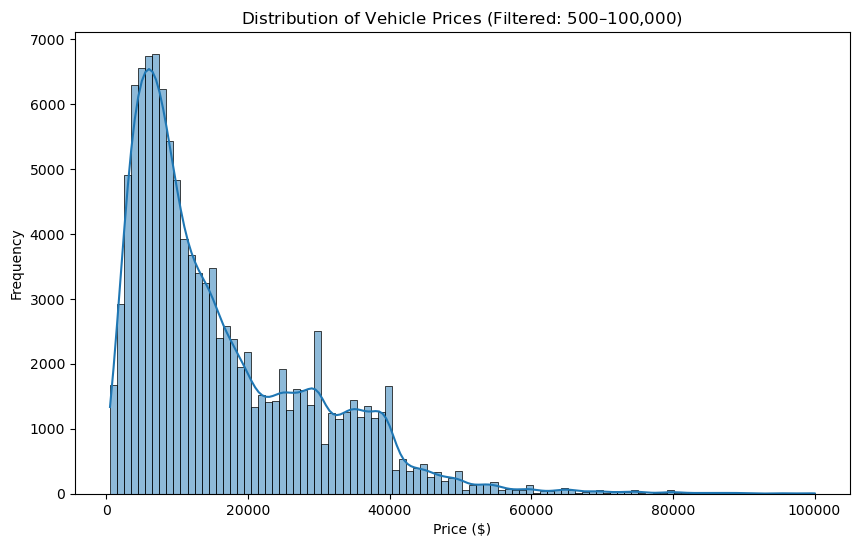

In [1441]:
df_plot = df[(df['price'] >= 500) & (df['price'] <= 100000)]
plt.figure(figsize=(10, 6))
sns.histplot(df_plot['price'], bins=100, kde=True)
plt.title('Distribution of Vehicle Prices (Filtered: $500–$100,000)')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

In [1442]:
df[df['price'] <= 500].shape

(6555, 12)

When we look at price, the first thing we notice is that there are a number of cars that have no value (price). This may be bad data or just really junky cars. These would have no value to a car dealer.

In [1443]:
df = df[df['price'] >= 500]

Next, checking for non-numeric data.

In [1444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115548 entries, 31 to 426878
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         115548 non-null  int64  
 1   year          115548 non-null  float64
 2   model         115548 non-null  object 
 3   condition     115548 non-null  object 
 4   cylinders     115548 non-null  object 
 5   fuel          115548 non-null  object 
 6   odometer      115548 non-null  float64
 7   transmission  115548 non-null  object 
 8   drive         115548 non-null  object 
 9   type          115548 non-null  object 
 10  paint_color   115548 non-null  object 
 11  state         115548 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 11.5+ MB


Most of the features are non-numeric. We will look at these individually.

#### Model
We dropped 'manufacturer' earlier because the manufacturer info was contained in the model. Unfortunately, this creates a new problem. There are a LOT of models.

In [1445]:
df['model'].nunique()

13740

Let's only keep the top 40 models. One-hot encode those models.

In [1446]:
top_models = df['model'].value_counts().nlargest(40).index
df['model_grouped'] = df['model'].apply(lambda x: x if x in top_models else 'other')
df_models_encoded = pd.get_dummies(df['model_grouped'], prefix='model', drop_first=True)
df = pd.concat([df, df_models_encoded], axis=1)
df = df.drop(columns=['model', 'model_grouped'])

#### Condition
Let's see what conditions we have.

In [1447]:
df['condition'].unique()

array(['excellent', 'good', 'new', 'fair', 'like new', 'salvage'],
      dtype=object)

Since condition implies quality, I'm going to say we can map these to a number instead of one-hot encoding.

In [1448]:
condition_map = {
    'salvage': 0,
    'fair': 1,
    'good': 2,
    'excellent': 3,
    'like new': 4,
    'new': 5
}
df['condition_num'] = df['condition'].map(condition_map)
df.drop(columns='condition', inplace=True)

#### Cylinders

In [1449]:
df['cylinders'].unique()

array(['6 cylinders', '8 cylinders', '4 cylinders', '5 cylinders',
       '10 cylinders', '3 cylinders', 'other', '12 cylinders'],
      dtype=object)

We need to convert cylinders to numbers. 'Other' poses a problem and will be treaded as the median.

In [1450]:
# Step 1: Extract numeric part from 'cylinders' and convert to float
df['cylinders_int'] = df['cylinders'].str.extract(r'(\d+)')[0].astype(float)

# Step 2: Calculate the median of existing numeric cylinder values
cylinder_median = df['cylinders_int'].median()

# Step 3: Replace 'other' with the median value in 'cylinders_int'
df.loc[df['cylinders'] == 'other', 'cylinders_int'] = cylinder_median

# Convert 'cylinders_int' from float to integer
df['cylinders_int'] = df['cylinders_int'].astype(int)

df.drop(columns='cylinders', inplace=True)

print(df['cylinders_int'].unique())

[ 6  8  4  5 10  3 12]


#### Fuel

In [1451]:
df['fuel'].unique()

array(['gas', 'diesel', 'other', 'hybrid', 'electric'], dtype=object)

One-hot encode fuel.

In [1452]:
df = pd.get_dummies(df, columns=['fuel'], drop_first=True)

#### Odometer

In [1453]:
missing_odometer_count = df['odometer'].isna().sum()
missing_odometer_count

0

#### Transmission

In [1454]:
df['transmission'].unique()

array(['automatic', 'other', 'manual'], dtype=object)

In [1455]:
df = pd.get_dummies(df, columns=['transmission'], drop_first=True)

#### Drive

In [1456]:
df['drive'].unique()

array(['rwd', '4wd', 'fwd'], dtype=object)

In [1457]:
df = pd.get_dummies(df, columns=['drive'], drop_first=True)

#### Type

In [1458]:
df['type'].unique()

array(['truck', 'pickup', 'other', 'coupe', 'mini-van', 'SUV', 'sedan',
       'offroad', 'bus', 'convertible', 'hatchback', 'wagon', 'van'],
      dtype=object)

In [1459]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

#### Paint Color

In [1460]:
df['paint_color'].unique()

array(['black', 'silver', 'grey', 'red', 'blue', 'white', 'brown',
       'yellow', 'green', 'custom', 'orange', 'purple'], dtype=object)

In [1461]:
# df = pd.get_dummies(df, columns=['paint_color'], drop_first=True)
df.drop(columns='paint_color', inplace=True)

#### State

In [1462]:
df['state'].unique()

array(['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
       'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma',
       'mi', 'mn', 'ms', 'mo', 'mt', 'nc', 'ne', 'nv', 'nj', 'nm', 'ny',
       'nh', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
       'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy'], dtype=object)

In [1463]:
# df = pd.get_dummies(df, columns=['state'], drop_first=True)
df.drop(columns='state', inplace=True)

#### Final initial model

In [1464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115548 entries, 31 to 426878
Data columns (total 65 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   price                         115548 non-null  int64  
 1   year                          115548 non-null  float64
 2   odometer                      115548 non-null  float64
 3   model_1500 crew cab big horn  115548 non-null  bool   
 4   model_2500                    115548 non-null  bool   
 5   model_4runner                 115548 non-null  bool   
 6   model_accord                  115548 non-null  bool   
 7   model_altima                  115548 non-null  bool   
 8   model_camaro ss coupe 2d      115548 non-null  bool   
 9   model_camry                   115548 non-null  bool   
 10  model_civic                   115548 non-null  bool   
 11  model_corolla                 115548 non-null  bool   
 12  model_corvette                115548 non-null  b

In [1465]:
df.shape

(115548, 65)

In [1466]:
df.head()

,price,year,odometer,model_1500 crew cab big horn,model_2500,model_4runner,model_accord,model_altima,model_camaro ss coupe 2d,model_camry,model_civic,model_corolla,model_corvette,model_corvette grand sport,model_cr-v,model_elantra,model_equinox,model_escape,model_explorer,model_f-150,model_f150,model_focus,model_fusion,model_grand caravan,model_grand cherokee,model_impala,model_jetta,model_malibu,model_mustang,model_mustang gt coupe 2d,model_odyssey,model_other,model_outback,model_prius,model_rav4,model_sierra 1500,model_silverado,model_silverado 1500,model_silverado 2500hd,model_sonata,model_tacoma,model_tahoe,model_wrangler,condition_num,cylinders_int,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,transmission_other,drive_fwd,drive_rwd,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
31,15000,2013.0,128000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,3,6,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
32,27990,2012.0,68696.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2,8,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
33,34590,2016.0,29499.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2,6,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
34,35000,2019.0,43000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,3,6,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
35,29990,2016.0,17302.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2,6,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [1467]:
X = df.drop(columns='price')
y = df['price']

In [1468]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1469]:
pipeline = Pipeline([
    ('transform', PolynomialFeatures(degree=2, include_bias = False)),
    ('scale', StandardScaler()),
    ('regression', Ridge(alpha = 10000))
])

In [1470]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform', PolynomialFeatures(include_bias=False)),
                ('scale', StandardScaler()),
                ('regression', Ridge(alpha=10000))])

In [1471]:
y_pred = pipeline.predict(X_test)

In [1472]:
mse = mean_squared_error(y_test, y_pred)
mse

604286816418430.0

In [1473]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: -0.0001


In [1474]:
# Prepare features and log-transformed target
X = df.drop(columns='price').select_dtypes(include=[np.number])
y = np.log1p(df['price'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])

# Define hyperparameter grid
param_grid = {
    'poly__degree': [1, 2],
    'ridge__alpha': [0.1, 1, 10, 100]
}

# Set up GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit
grid.fit(X_train, y_train)

# Predict using best estimator
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"Best Params: {grid.best_params_}")
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'poly__degree': 2, 'ridge__alpha': 100}
RMSE: $24,585,340.69
R² Score: -0.0003


In [1477]:
feature_names = best_model.named_steps['poly'].get_feature_names_out(X.columns)
coefficients = best_model.named_steps['ridge'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)
coef_df

,Feature,Coefficient
0,year,0.697142
1,odometer,-0.511676
3,cylinders_int,0.350423
4,year^2,0.131615
2,condition_num,0.108027
11,condition_num^2,-0.059019
6,year condition_num,-0.040678
9,odometer condition_num,-0.013651
7,year cylinders_int,0.012779
8,odometer^2,0.009903


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Takewaays
* year - newer vehicles are more expensive
* odometer - more miles means a lower price
* cylinders_int - more cylinders (bigger engine) means higher price
* condition_num - better condition slightly increases price

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.